In [1]:
import torch
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
import importlib

from datasets import MuscimaObjects
from datasets.MuscimaObjects import get_transform
from datasets.MuscimaMeasures import visualize_bboxes

from semantics.SystemObjects import *
from semantics import SoundObjects


Initialized module


In [2]:
# load the measures model
SAVED_MODEL_MEASURES = os.path.join('saved_models', 'measures_5_layers.pt')
model = torch.load(SAVED_MODEL_MEASURES)
model.eval()
# load the object annotations
MUSCIMAROOT = 'muscima'
dataset = MuscimaObjects.MuscimaObjects(
    MUSCIMAROOT, MuscimaObjects.__pitch_objects__, get_transform(train=True))
dataset_test = MuscimaObjects.MuscimaObjects(
    MUSCIMAROOT, MuscimaObjects.__pitch_objects__, get_transform(train=False))
# splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])


In [3]:
image_index = 0

image, target = dataset_test[image_index]


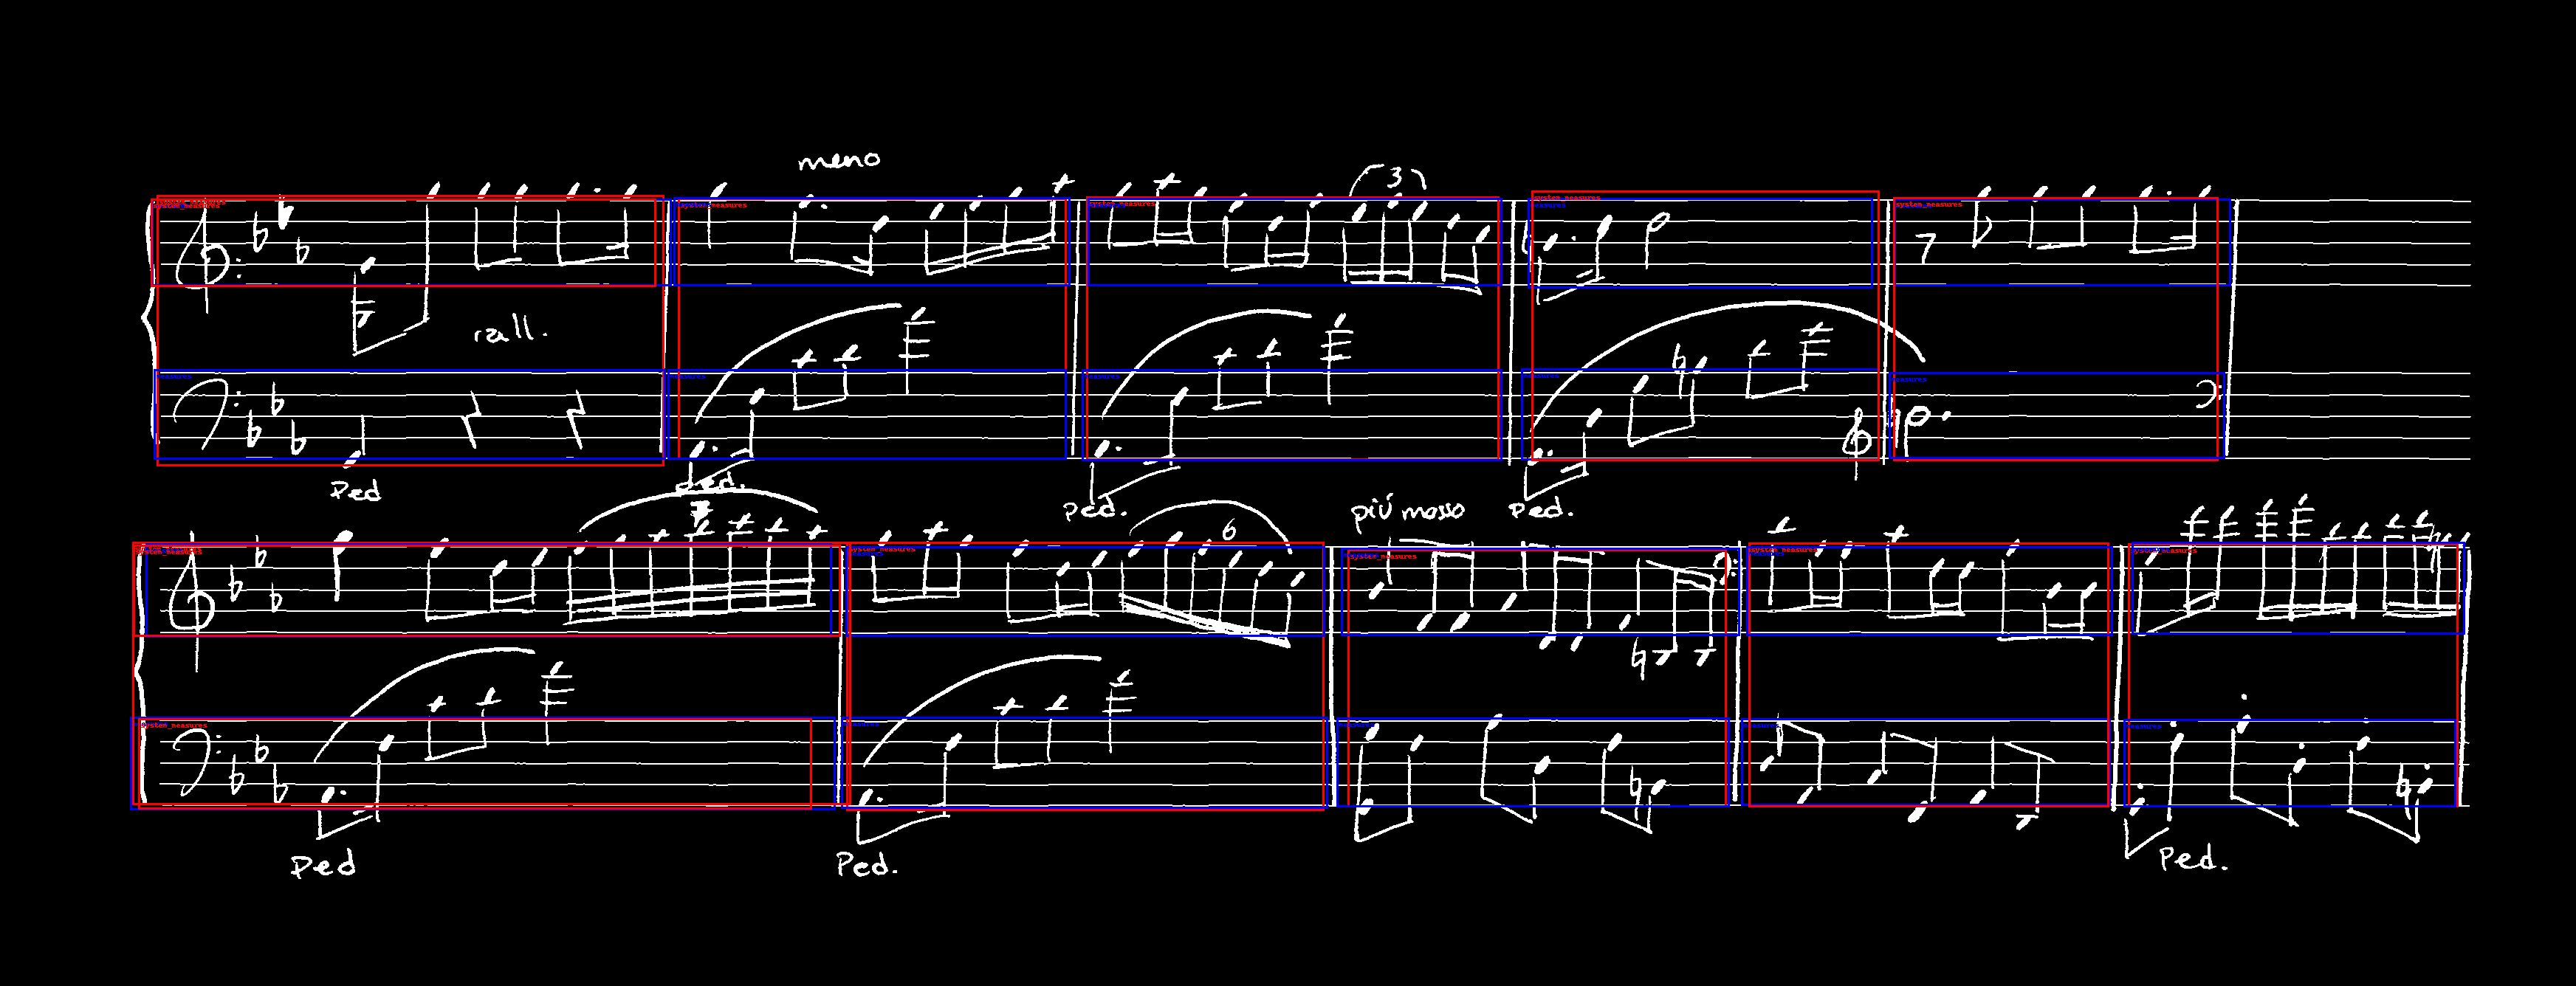

In [4]:
sample_image = [np.repeat(image, 3, 0)]
images = list(img.to(torch.device('cuda')) for img in sample_image)
detections = model(images)

visualize_bboxes(images[0], detections[0])


In [5]:
MuscimaObjects.__pitch_objects__


['noteheadFull',
 'noteheadHalf',
 'noteheadWhole',
 'accidentalSharp',
 'accidentalFlat',
 'accidentalNatural',
 'gCflef',
 'fClef',
 'cClef']

In [6]:
factory = SongFactory(images[0], detections[0], target)


In [7]:
objects = factory.song.systems[0].objects

In [8]:
factory.song.systems[0].boundaries

array([0.        , 0.33322063])

In [13]:
factory.song.systems[0] < factory.song.systems[1]

True

In [9]:
factory.song.systems[0].measures[0].objects

In [12]:
list(filter(lambda obj: 0.75 > obj.x > 0.5, objects))

In [16]:
len(factory.song.systems[0].measure_boxes)

5

In [1]:
factory.song.systems[0].bbox()

NameError: name 'factory' is not defined

In [ ]:
staff_measures = factory.staff_measures
height, width = factory.height, factory.width
sample_staff = factory.staves[1]


In [ ]:
some_measures = np.array([[0.59070754, 0.37419364, 0.7296071 , 0.46695033],
       [0.05971682, 0.37450802, 0.25843462, 0.46590468],
       [0.420092  , 0.374791  , 0.58300257, 0.4671924 ],
       [0.25922823, 0.37479445, 0.41415334, 0.46614403],
       [0.7334418 , 0.37778202, 0.8635829 , 0.46550924]],)

In [ ]:
np.array(sample_staff.measures)

array([[0.59070754, 0.37419364, 0.7296071 , 0.46695033],
       [0.05971682, 0.37450802, 0.25843462, 0.46590468],
       [0.420092  , 0.374791  , 0.58300257, 0.4671924 ],
       [0.25922823, 0.37479445, 0.41415334, 0.46614403],
       [0.7334418 , 0.37778202, 0.8635829 , 0.46550924]], dtype=float32)

In [ ]:
print(sample_staff.getStats())
print(sample_staff.getStaffLinesBBs())

stafflineBBs = sample_staff.getStaffLinesBBs()
stafflineBBs[:, [1, 3]] = stafflineBBs[:, [1, 3]]*height
stafflineBBs[:, [0, 2]] = stafflineBBs[:, [0, 2]]*width


{'top': 0.37521383, 'bottom': 0.46634012, 'left': 0.059716824, 'right': 0.8635829, 'center': 0.42077697813510895, 'num': 5}
[[0.05971682 0.37521383 0.86358291 0.3979954 ]
 [0.05971682 0.3979954  0.86358291 0.42077698]
 [0.05971682 0.42077698 0.86358291 0.44355855]
 [0.05971682 0.44355855 0.86358291 0.46634012]]


In [ ]:
def visualize(sample_image, boxes):
    sample_image = (images[0]*255).type(torch.ByteTensor)

    image_with_bb = draw_bounding_boxes(
        sample_image, torch.from_numpy(boxes), fill=True, colors="Red")
    
    return Image.fromarray(np.moveaxis(image_with_bb.numpy(), 0, -1))


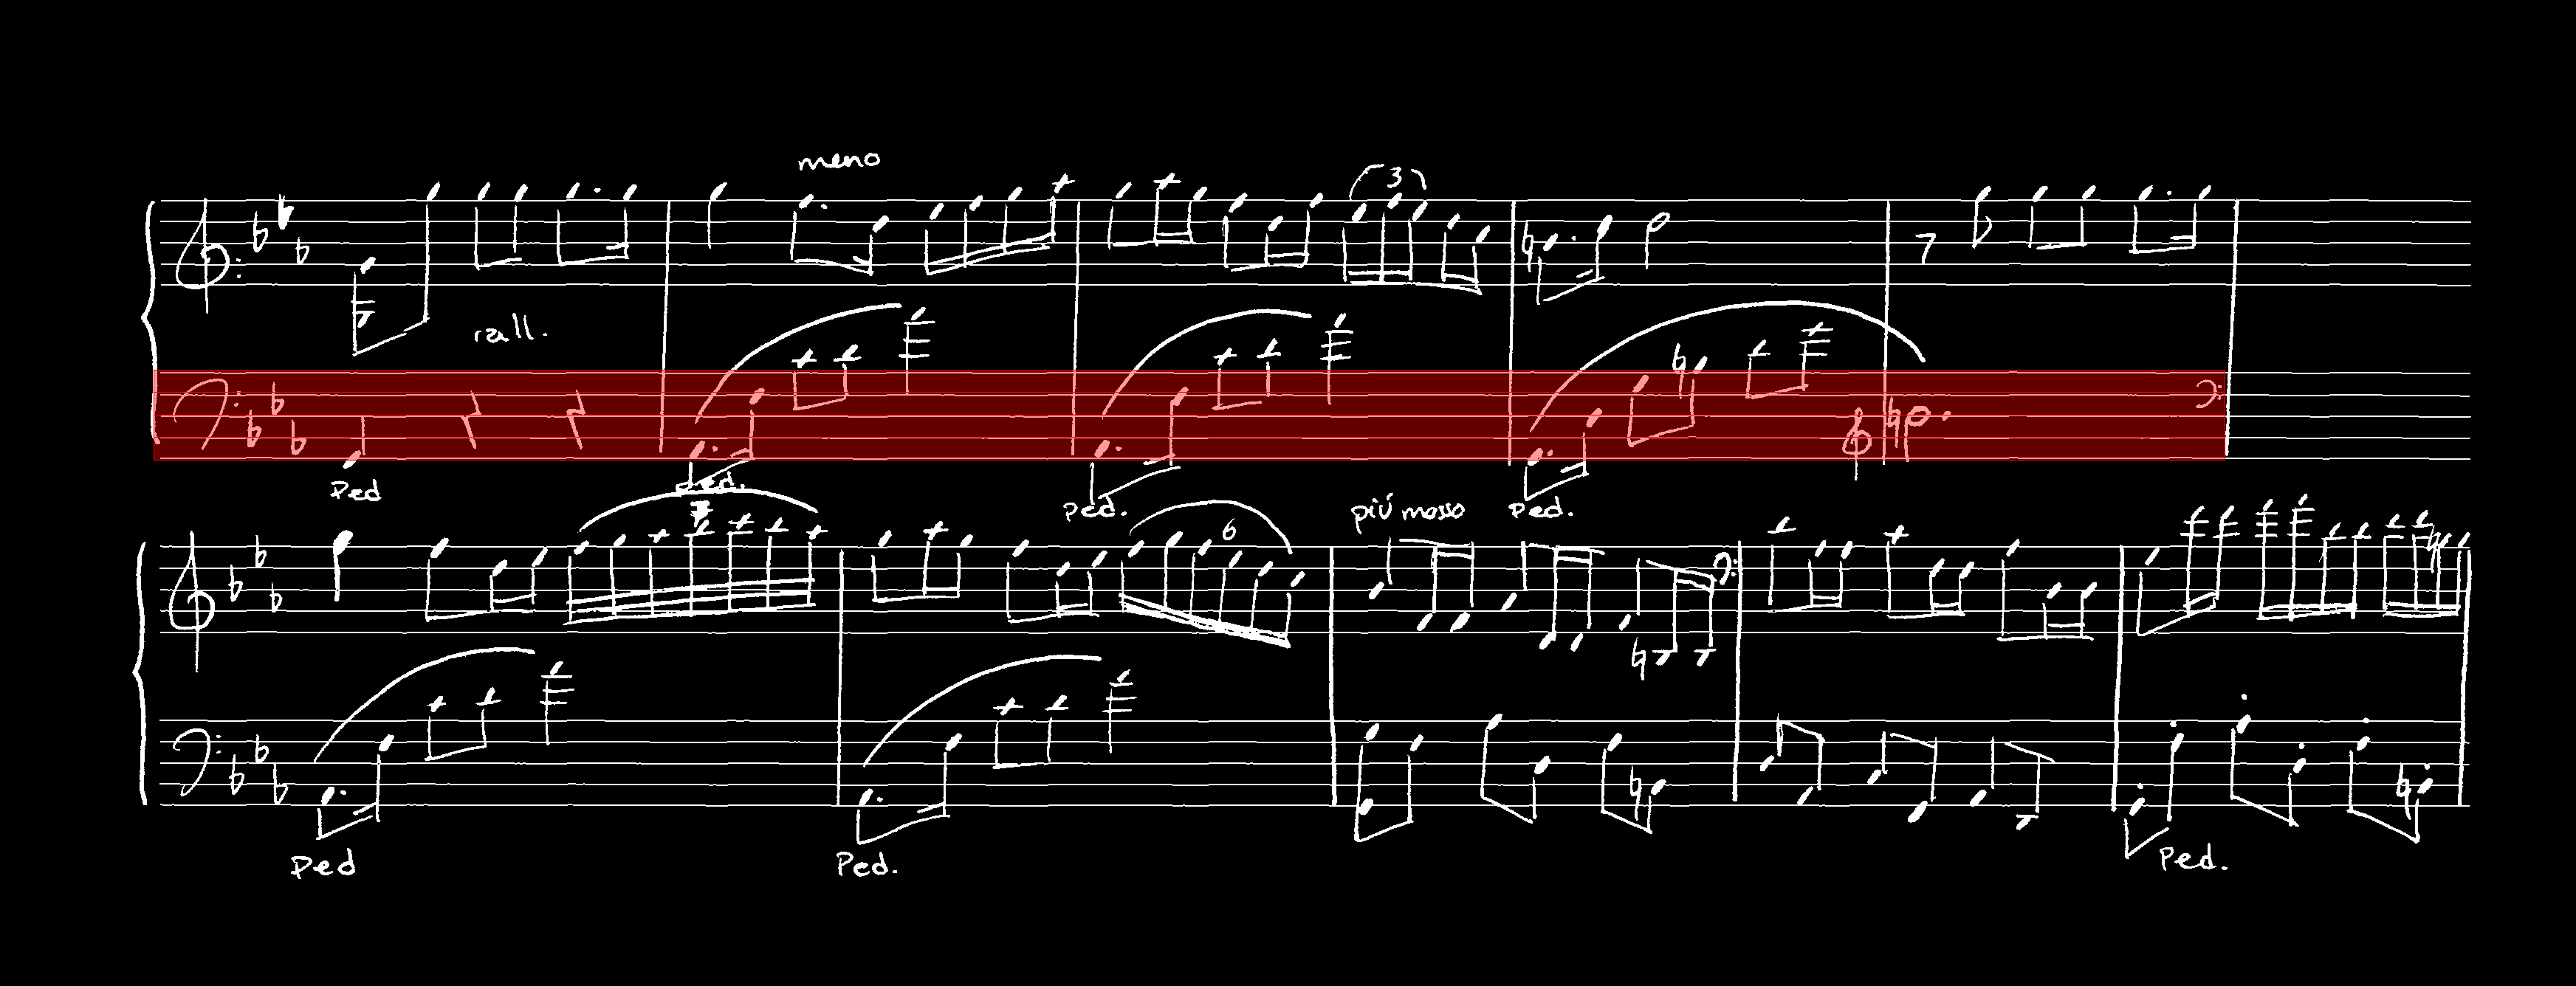

In [ ]:

sample_image = (images[0]*255).type(torch.ByteTensor)

image_with_bb = draw_bounding_boxes(
    sample_image, torch.from_numpy(stafflineBBs), fill=True, colors="Red")

Image.fromarray(np.moveaxis(image_with_bb.numpy(), 0, -1))


In [ ]:
factory.song

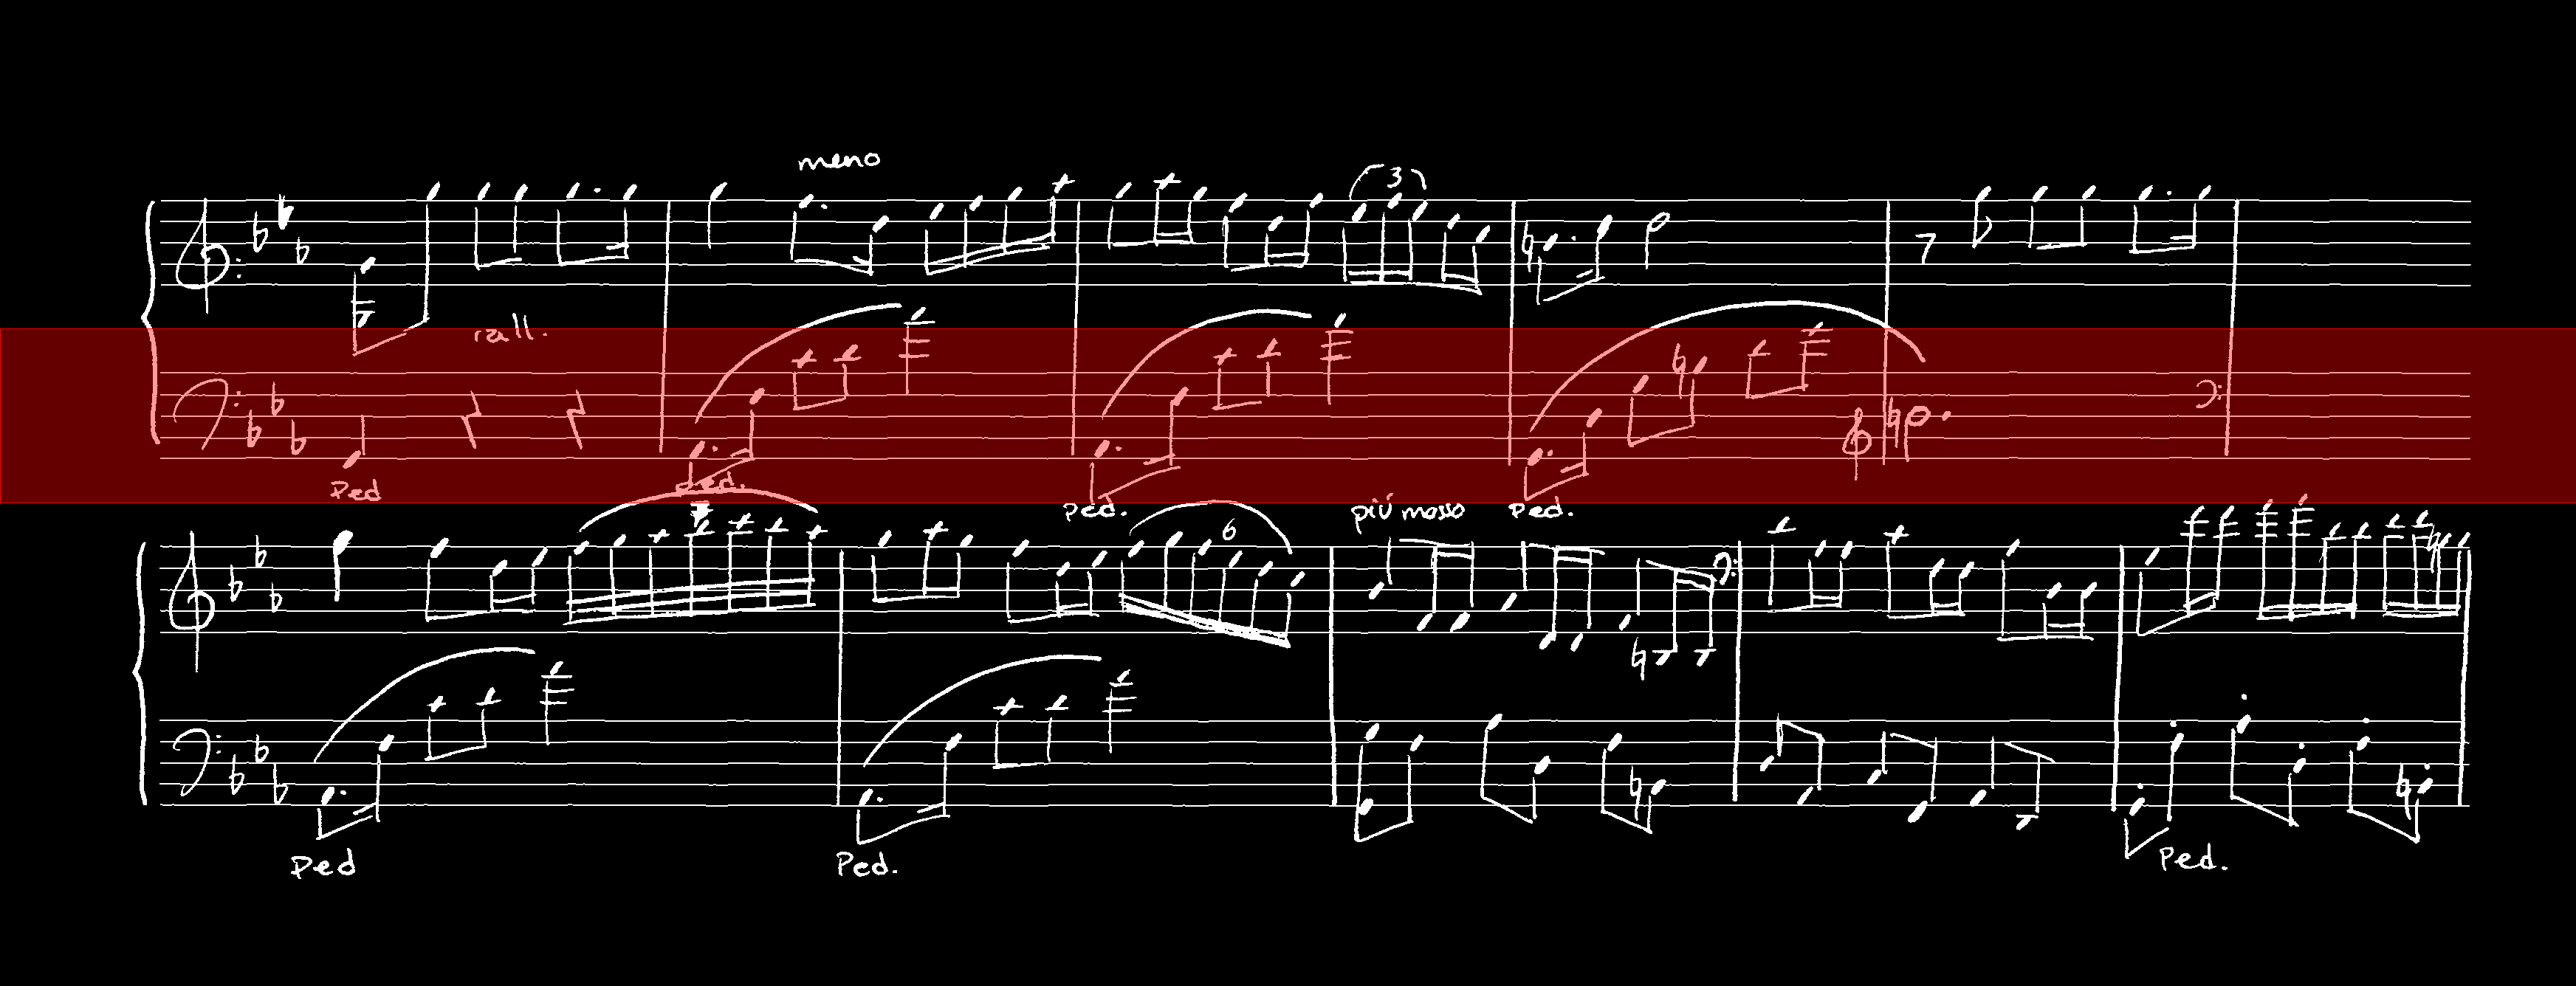

In [ ]:
system1 = denormalize_bboxes(factory.song.systems[1].bbox(), sample_image)

visualize(sample_image, system1)

In [ ]:
myObj = factory.song.systems[0].objects[6]

In [ ]:
bottom = factory.song.systems[0].staves.getStats()['bottom']
top = factory.song.systems[0].staves.getStats()['top']

gap = (bottom - top)/4

myObj.relativePos(bottom, gap)

9

In [ ]:
objectDict = factory.song.systems[0].objects

In [ ]:
pitch_objects = ['noteheadFull', 'noteheadHalf', 'noteheadWhole', 'accidentalSharp', 'accidentalFlat', 'accidentalNatural',
                    'gCflef', 'fClef', 'cClef']
objectDict['labels']

array(['noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'accidentalFlat',
       'noteheadFull', 'noteheadFull', 'noteheadHalf', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'accidentalFlat', 'noteheadFull',
       'noteheadFull', 'accidentalNatural', 'accidentalFlat',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull'], dtype='<U17')

In [ ]:
objectDict['labels']

array(['noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'accidentalFlat',
       'noteheadFull', 'noteheadFull', 'noteheadHalf', 'noteheadFull',
       'noteheadFull', 'noteheadFull', 'accidentalFlat', 'noteheadFull',
       'noteheadFull', 'accidentalNatural', 'accidentalFlat',
       'noteheadFull', 'noteheadFull', 'noteheadFull', 'noteheadFull',
       'noteheadFull'], dtype='<U17')